In [25]:
import datetime
import os
import sys

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
from hydra import initialize, compose
import pickle
from glob import glob

# set paths to various directories based on the machine this code is being executed on
with initialize(version_base=None, config_path='../../config'):
    config = compose(config_name='config.yaml')  # overrides=['machine=uzay']

array_dir, data_dir, figure_dir, pickle_dir, repo_dir  = config.machine.array_dir, config.machine.data_dir, config.machine.figure_dir, config.machine.pickle_dir, config.machine.repo_dir

# enable use of local modules
if repo_dir not in sys.path:
    sys.path.append(repo_dir)

# set matplotlib style
plt.style.use(f'{repo_dir}/mejiro/mplstyle/science.mplstyle')

from mejiro.lenses.test import SampleSkyPyLens
from mejiro.plots import diagnostic_plot, plot, plot_util, overplot
from mejiro.analysis import stats
from mejiro.utils import util
from mejiro.helpers import pyhalo

In [26]:
index = 0
band = 'f106'
filter_name = 'Y106'

path = os.path.join(config.machine.dir_03, f'lens_dict_{str(index).zfill(8)}_{band.lower()}')
lens_dict = util.unpickle(path)

lens = lens_dict['lens']
# model = lens_dict['model']
model = lens.get_array(num_pix=45, side=4.95)

(45, 45)


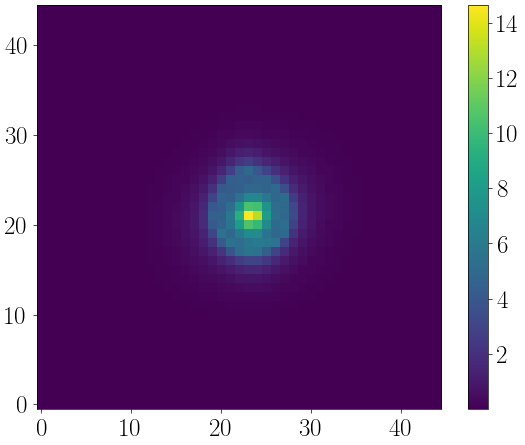

In [27]:
print(model.shape)
plot.plot(model, colorbar=True)

In [28]:
import galsim
from galsim import roman
from galsim import InterpolatedImage

In [29]:
roman_filters = roman.getBandpasses(AB_zeropoint=True)
bandpass = roman_filters[filter_name]

use_SCA = 1

ra_targ = galsim.Angle.from_hms('16:01:41.01257')
dec_targ = galsim.Angle.from_dms('66:48:10.1312')
targ_pos = galsim.CelestialCoord(ra=ra_targ, dec=dec_targ)

date = datetime.datetime(2025, 5, 16)

wcs_dict = roman.getWCS(world_pos=targ_pos, SCAs=use_SCA, date=date)
wcs = wcs_dict[use_SCA]

In [30]:
pixel_side, _ = model.shape

In [31]:
full_image = galsim.Image(model * 50, scale=0.11, copy=True)
# full_image = galsim.InterpolatedImage(galsim.Image(model), scale = 0.03667, flux = 1000)

In [34]:
# Create the PSF
# We are ignoring the position-dependence of the PSF within each SCA, just using the PSF
# at the center of the sensor.
# Note: pupil_bin=8 is faster at the expense of lower resolution for the diffraction spikes.
# The n_waves keyword calculates this many PSF models in advance at different wavelengths
# which we can interpolate between when drawing the galaxies.  For more accuracy w.r.t.
# the chromaticity, you can increase this value of `n_waves`.
# Note: Removing n_waves parameter would actually be both slower and less accurate, since
# the OpticalPSF model would redo the wavefront calculation for each object, and then
# would still make an approximation that would be similar to n_waves=3.
sca_pos = galsim.PositionD(100, 100)
psf = roman.getPSF(use_SCA, filter_name, SCA_pos=sca_pos, n_waves=10, wcs=wcs, pupil_bin=8)

# Set up the full image for the galaxies
# full_image = galsim.ImageF(pixel_side, pixel_side, wcs=wcs)

# Also separately build up the sky image, which we need to get the noise right,
# even though we'll subtract off the expectation of the sky image.
sky_image = galsim.ImageF(pixel_side, pixel_side, wcs=wcs)

# We have one rng for image-level stuff, and two others for the stars and galaxies.
# There are simpler ways to do this in a python script (e.g. probably only need 2
# rngs, not 3), but this way of setting it up matches the way the config file initializes
# the random number generators.
# Also, note that the second seed given in the config file, doesn't get the
# BaseDeviate(...).raw() treatment.  Only the first item, which parses as an int.
# When a random_seed config item is already a dict, GalSim leaves it as is.
image_rng = galsim.UniformDeviate(42)

# Start with the flux from the sky. This is a little easier to do first before adding
# the light from the objects, since we will have to apply Poisson noise to the sky flux
# manually, but the photon shooting will automatically include Poisson noise for the
# objects.

# First we get the amount of zodaical light for a position corresponding to the center of
# this SCA.  The results are provided in units of e-/arcsec^2, using the default Roman
# exposure time since we did not explicitly specify one.  Then we multiply this by a factor
# >1 to account for the amount of stray light that is expected.  If we do not provide a date
# for the observation, then it will assume that it's the vernal equinox (sun at (0,0) in
# ecliptic coordinates) in 2025.
SCA_cent_pos = wcs.toWorld(sky_image.true_center)
sky_level = roman.getSkyLevel(bandpass, world_pos=SCA_cent_pos)
sky_level *= (1.0 + roman.stray_light_fraction)

# Note that makeSkyImage() takes a bit of time. If you do not care about the variable pixel
# scale, you could simply compute an approximate sky level in e-/pix by multiplying
# sky_level by roman.pixel_scale**2, and add that to sky_image.
wcs.makeSkyImage(sky_image, sky_level)

# The other background is the expected thermal backgrounds in this band.
# These are provided in e-/pix/s, so we have to multiply by the exposure time.
sky_image += roman.thermal_backgrounds[filter_name] * roman.exptime

In [35]:
# At this point in the image generation process, an integer number of photons gets
# detected.  Because of how GalSim's photon shooting works for InterpolatedImage
# (used implicitly in the PSF implementation), the image has non-integral values at this
# point.  So the first thing we do is quantize that to an integer number of photons.
full_image.quantize()

# Add the sky image.  Note: the galaxies already have Poisson noise because we are photon
# shooting, but the sky image does not.  We want to preserve the expectation value of the
# sky image (to subtract it off below), so we need a copy, which we can add noise to.
poisson_noise = galsim.PoissonNoise(image_rng)
sky_image_realized = sky_image.copy()
sky_image_realized.addNoise(poisson_noise)
full_image += sky_image_realized

# Now that all sources of signal (from astronomical objects and background) have been added
# to the image, we can start adding noise and detector effects.  There is a utility,
# galsim.roman.allDetectorEffects(), that can apply ALL implemented noise and detector
# effects in the proper order.  Here we step through the process and explain these in a bit
# more detail without using that utility.

# The subsequent steps account for the non-ideality of the detectors.

# 1) Reciprocity failure:
# Reciprocity, in the context of photography, is the inverse relationship between the
# incident flux (I) of a source object and the exposure time (t) required to produce a given
# response(p) in the detector, i.e., p = I*t. However, in NIR detectors, this relation does
# not hold always. The pixel response to a high flux is larger than its response to a low
# flux. This flux-dependent non-linearity is known as 'reciprocity failure', and the
# approximate amount of reciprocity failure for the Roman detectors is known, so we can
# include this detector effect in our images.

# If we had wanted to, we could have specified a different exposure time than the default
# one for Roman, but otherwise the following routine does not take any arguments.
roman.addReciprocityFailure(full_image)
print('Included reciprocity failure in {0}-band image'.format(filter_name))

# 2) Adding dark current to the image:
# Even when the detector is unexposed to any radiation, the electron-hole pairs that
# are generated within the depletion region due to finite temperature are swept by the
# high electric field at the junction of the photodiode. This small reverse bias
# leakage current is referred to as 'dark current'. It is specified by the average
# number of electrons reaching the detectors per unit time and has an associated
# Poisson noise since it is a random event.
dark_current = roman.dark_current*roman.exptime
dark_noise = galsim.DeviateNoise(galsim.PoissonDeviate(image_rng, dark_current))
full_image.addNoise(dark_noise)
sky_image += dark_current # (also want to subtract this expectation value along with sky)

# NOTE: Sky level and dark current might appear like a constant background that can be
# simply subtracted. However, these contribute to the shot noise and matter for the
# non-linear effects that follow. Hence, these must be included at this stage of the
# image generation process. We subtract these backgrounds in the end.

# 3) Applying a quadratic non-linearity:
# In order to convert the units from electrons to ADU, we must use the gain factor. The gain
# has a weak dependency on the charge present in each pixel. This dependency is accounted
# for by changing the pixel values (in electrons) and applying a constant nominal gain
# later, which is unity in our demo.

# Apply the Roman nonlinearity routine, which knows all about the nonlinearity expected in
# the Roman detectors.
roman.applyNonlinearity(full_image)

# Note that users who wish to apply some other nonlinearity function (perhaps for other NIR
# detectors, or for CCDs) can use the more general nonlinearity routine, which uses the
# following syntax:
# full_image.applyNonlinearity(NLfunc=NLfunc)
# with NLfunc being a callable function that specifies how the output image pixel values
# should relate to the input ones.
print('Applied nonlinearity to {0}-band image'.format(filter_name))

# 4) Including Interpixel capacitance:
# The voltage read at a given pixel location is influenced by the charges present in the
# neighboring pixel locations due to capacitive coupling of sense nodes. This interpixel
# capacitance effect is modeled as a linear effect that is described as a convolution of a
# 3x3 kernel with the image.  The Roman IPC routine knows about the kernel already, so the
# user does not have to supply it.
roman.applyIPC(full_image)
print('Applied interpixel capacitance to {0}-band image'.format(filter_name))

# 5) Adding read noise:
# Read noise is the noise due to the on-chip amplifier that converts the charge into an
# analog voltage.  We already applied the Poisson noise due to the sky level, so read noise
# should just be added as Gaussian noise:
read_noise = galsim.GaussianNoise(image_rng, sigma=roman.read_noise)
full_image.addNoise(read_noise)
print('Added readnoise to {0}-band image'.format(filter_name))

# We divide by the gain to convert from e- to ADU. Currently, the gain value in the Roman
# module is just set to 1, since we don't know what the exact gain will be, although it is
# expected to be approximately 1. Eventually, this may change when the camera is assembled,
# and there may be a different value for each SCA. For now, there is just a single number,
# which is equal to 1.
full_image /= roman.gain
sky_image /= roman.gain

# Finally, the analog-to-digital converter reads in an integer value.
full_image.quantize()
sky_image.quantize()
# Note that the image type after this step is still a float.  If we want to actually
# get integer values, we can do new_img = galsim.Image(full_image, dtype=int)

Included reciprocity failure in Y106-band image
Applied nonlinearity to Y106-band image
Applied interpixel capacitance to Y106-band image
Added readnoise to Y106-band image


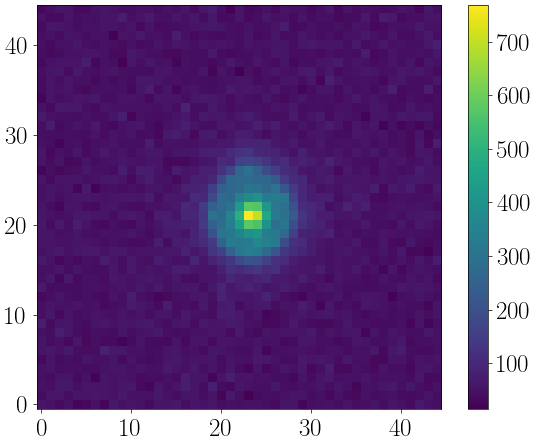

In [36]:
plot.plot(full_image.array, colorbar=True)

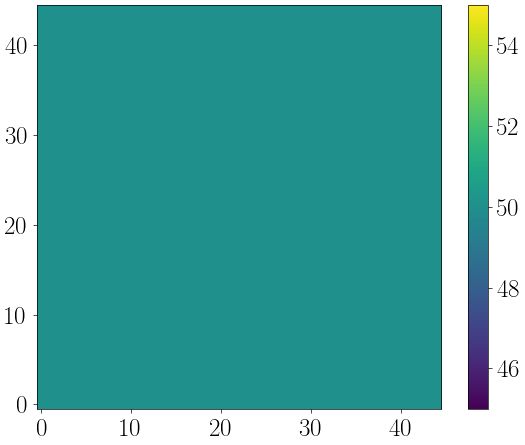

In [37]:
plot.plot(sky_image.array, colorbar=True)

In [38]:
# # Write the final image to a file.
# out_filename = 'demo13_{0}.fits'.format(filter_name)
# full_image.write(out_filename)